In [1]:
#!conda install intake fsspec intake-xarray -c conda-forge -y

In [2]:
#!pip install climetlab

#!pip install climetlab_s2s_ai_challenge

In [3]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

## Calculate skill of S2S model ECMWF for daily global reforecasts

In [4]:
import climpred
import xarray as xr

<IPython.core.display.Javascript object>

### Get hindcast

S2S output is hosted on the ECMWF S3 cloud, see https://github.com/ecmwf-lab/climetlab-s2s-ai-challenge

Two ways to access:

- direct access via `intake_xarray` and integrated caching via `fsspec`
- `climetlab` with integrated caching

Resources:

- https://intake.readthedocs.io/en/latest/
- https://intake-xarray.readthedocs.io/en/latest/
- https://intake-thredds.readthedocs.io/en/latest/
- https://filesystem-spec.readthedocs.io/en/latest/
- https://climetlab.readthedocs.io/en/latest/

Hindcasts/Reforecasts are stored in `netcdf` or `grib` format.
For each initialization `init` (CF convention: `standard_name=forecast_reference_time`) in the year 2020 (see `dates`), reforecasts are available started on the same `dayofyear` from 2000-2019.

Here we get the reforecast skill for 2m temperature of forecasts initialized 2nd Jan 2000-2019.

In [5]:
dates = xr.cftime_range(start="2020-01-02", freq="7D", end="2020-12-31")

<IPython.core.display.Javascript object>

In [6]:
var = "t2m"
date = dates[0].strftime("%Y%m%d")
date

'20200102'

<IPython.core.display.Javascript object>

#### `intake_xarray`

In [7]:
import intake
import fsspec
from aiohttp import ClientSession, ClientTimeout

timeout = ClientTimeout(total=600)
fsspec.config.conf["https"] = dict(client_kwargs={"timeout": timeout})

import intake_xarray

cache_path = "my_caching_folder"
fsspec.config.conf["simplecache"] = {"cache_storage": cache_path, "same_names": True}

<IPython.core.display.Javascript object>

In [8]:
hind = intake_xarray.NetCDFSource(
    f"simplecache::https://storage.ecmwf.europeanweather.cloud/s2s-ai-challenge/data/training-input/ecmwf-hindcast/0.3.0/netcdf/ecmwf-hindcast-{var}-{date}.nc"
).to_dask()

<IPython.core.display.Javascript object>

#### `climetlab`

`climetlab` wraps `cdsapi` to download from the Copernicus Climate Data Store (CDS) and from plug-in sources:

- https://climetlab.readthedocs.io/en/latest/
- https://github.com/ecmwf-lab/climetlab-s2s-ai-challenge
- https://cds.climate.copernicus.eu/cdsapp#!/home
- https://github.com/ecmwf/cdsapi/

In [9]:
import climetlab

<IPython.core.display.Javascript object>

In [10]:
hind_climetlab = climetlab.load_dataset(
    "s2s-ai-challenge-training-input",
    origin="ecmwf",
    date=date,
    parameter=var,
    format="netcdf",
).to_xarray()

By downloading data from this dataset, you agree to the terms and conditions defined at https://apps.ecmwf.int/datasets/data/s2s/licence/. If you do not agree with such terms, do not download the data. 


  0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [11]:
hind_climetlab.coords

Coordinates:
  * realization    (realization) int64 0 1 2 3 4 5 6 7 8 9 10
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2019-01-02
  * lead_time      (lead_time) timedelta64[ns] 1 days 2 days ... 45 days 46 days
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (forecast_time, lead_time) datetime64[ns] dask.array<chunksize=(20, 46), meta=np.ndarray>

<IPython.core.display.Javascript object>

### Get observations

Choose from:

- CPC
- ERA5

#### CPC as observations
compare against CPC observations: http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/

In [12]:
cache = True
if not cache:
    start_year = 2000
    chunk_dim = "T"
    tmin = xr.open_dataset(
        "http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmin/dods",
        chunks={chunk_dim: "auto"},
    ).rename({"tmin": "t"})
    tmax = xr.open_dataset(
        "http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmax/dods",
        chunks={chunk_dim: "auto"},
    ).rename({"tmax": "t"})
    t = xr.concat([tmin, tmax], "m").mean("m")

    t["T"] = xr.cftime_range(start="1979-01-01", freq="1D", periods=t.T.size)

    t = t.rename({"X": "longitude", "Y": "latitude", "T": "time"}).sel(
        time=slice(f"{start_year-1}-12-24", None)
    )

    t["t"].attrs = tmin["t"].attrs
    t["t"].attrs["long_name"] = "Daily Temperature"
    t = t.rename({"t": "2t"}) + 273.15  # convert to K
    t = t.interp_like(
        hind.isel(lead=0, member=0, init=0, drop=True)
    )  # algin spatial grid
    t.to_zarr(
        "my_caching_folder/obs.zarr", mode="w", consolidated=True
    )  # save intermediate
else:
    obs = xr.open_zarr("my_caching_folder/obs.zarr").compute()

<IPython.core.display.Javascript object>

#### ERA5 as observations

compare against ERA5 reanalysis

In [13]:
hind_times = hind.set_coords("valid_time").valid_time.values.flatten()

# takes a while, continue with obs from above
obs_era = climetlab.load_source(
    "cds",
    "reanalysis-era5-single-levels",
    product_type="reanalysis",
    time=["00:00"],
    grid=[1.5, 1.5],
    param="2t",
    date=hind_times,
).to_xarray()

<IPython.core.display.Javascript object>

### Forecast verification with `climpred.HindcastEnsemble`

In [14]:
# PredictionEnsemble converts `lead_time` to `lead` due to standard_name 'forecast_period' and
#                             pd.Timedelta to `int` and set lead.attrs['units'] accordingly
hind.coords

Coordinates:
  * realization    (realization) int64 0 1
  * forecast_time  (forecast_time) datetime64[ns] 2000-01-02 ... 2019-01-02
  * lead_time      (lead_time) timedelta64[ns] 1 days 2 days 3 days
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5

<IPython.core.display.Javascript object>

In [15]:
hindcast = climpred.HindcastEnsemble(hind.drop("valid_time")).add_observations(obs)

metric_kwargs = dict(
    metric="rmse", comparison="e2o", alignment="same_inits", dim="init"
)

/Users/aaron.spring/Coding/climpred/climpred/checks.py:234: UserWarning: Did not find dimension "init", but renamed dimension forecast_time with CF-complying standard_name "forecast_reference_time" to init.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/checks.py:234: UserWarning: Did not find dimension "member", but renamed dimension realization with CF-complying standard_name "realization" to member.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/checks.py:234: UserWarning: Did not find dimension "lead", but renamed dimension lead_time with CF-complying standard_name "forecast_period" to lead.
  warnings.warn(


<IPython.core.display.Javascript object>

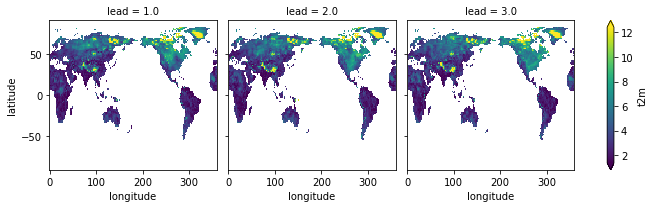

<IPython.core.display.Javascript object>

In [16]:
skill = hindcast.verify(**metric_kwargs)
skill[var].plot(col="lead", robust=True)

In [17]:
# still experimental, help appreciated https://github.com/pangeo-data/climpred/issues/605
with climpred.set_options(seasonality="month"):
    hindcast = hindcast.remove_bias(metric_kwargs["alignment"], cross_validate=False)

/Users/aaron.spring/Coding/climpred/climpred/bias_removal.py:138: UserWarning: HindcastEnsemble.remove_bias() is still experimental and is only tested for annual leads. Please consider contributing to https://github.com/pangeo-data/climpred/issues/605
  warnings.warn(


<IPython.core.display.Javascript object>

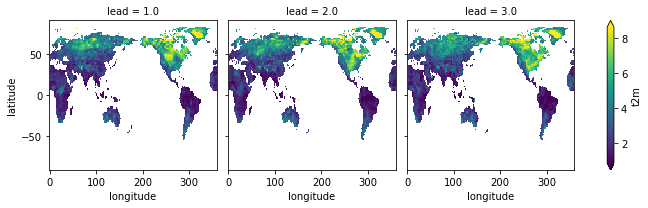

<IPython.core.display.Javascript object>

In [18]:
skill = hindcast.verify(**metric_kwargs)
skill[var].plot(col="lead", robust=True)